<h1 style="color:blue;">Forecasting the Number of Page Views</h1>

# Business Problem:


An ads and marketing company is helping businesses elicit maximum clicks @ minimum cost. They are building an ad infrastructure to help businesses promote themselves easily, effectively, and economically. The interplay of 3 AI modules - Design, Dispense, and Decipher, come together to make it this an end-to-end 3 step process digital advertising solution for all.

The objective here is to understand the per-page view report for different Wikipedia pages for 550 days and forecast the number of views so their data science team can predict and optimise Ad placement for their clients.

*The clients could belong to different regions, and hence they need data on how their ads will perform on pages in different languages.*


# Importing Libaries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pickle
from prettytable import PrettyTable
from tqdm import tqdm
import os
import datetime
from sklearn.preprocessing import StandardScaler

# Understanding the Data

## Quick Look at the data

__Loading the Data__

In [ ]:
data_path = f'data.csv'
df = pd.read_csv(data_path)

__Data Dimension__

In [ ]:
df.shape

(145063, 551)

__Summary:__

We have 145063 data points, and 551 features

__How the data looks like?__

In [ ]:
df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [ ]:
df.loc[145031]['Page']

'Anexo:Tenis_en_los_Juegos_Olímpicos_de_Río_de_Janeiro_2016_es.wikipedia.org_all-access_spider'

__Findings:__
- The dataset contains per page view report for different wikipedia pages for 550 days
- The page names are given in the following format: `SPECIFIC NAME _ LANGUAGE.wikipedia.org _ ACCESS TYPE _ ACCESS ORIGIN`
- There are missing page view reports for many days


## Some basic checks


### Why missing values?

In [ ]:
unique_trend = df.iloc[:, 1:].isnull().sum()

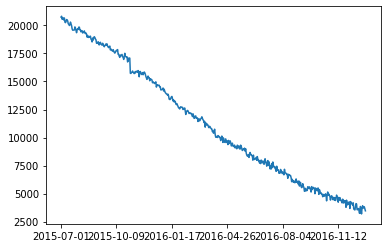

In [ ]:
unique_trend.plot()

__Findings__
- We have page view reports from 2015-07-01 to 2016-12-31. 
- The number of missing values decreases over time

__Possible explanations:__
1. Many of these pages were not even live in the beginning of the monitoring window, and as such, there are no page views recorded for them.  Hence we see a high number on the left side.
2. Missing values on the right side suggests, these pages are very unpopular, and thus no views. 

__Countermeasures:__
- We will try to investigate the pages with low views, and handle them accordingly in the further analysis

### Cleaning less-useful pages

In [ ]:
np.random.seed(19)
df.sample(20)['Page'].values

array(['Trans-Pacific_Partnership_en.wikipedia.org_mobile-web_all-agents',
       'Джек_Ричер_ru.wikipedia.org_all-access_all-agents',
       'Special:MyLanguage/Project:Visual_identity_www.mediawiki.org_mobile-web_all-agents',
       '少年ライフル魔事件_ja.wikipedia.org_all-access_spider',
       'Мальцев,_Вячеслав_Вячеславович_ru.wikipedia.org_all-access_all-agents',
       'Maladie_de_Lyme_fr.wikipedia.org_desktop_all-agents',
       'Летние_Паралимпийские_игры_2016_ru.wikipedia.org_all-access_all-agents',
       'Блок,_Александр_Александрович_ru.wikipedia.org_all-access_spider',
       'Ferdinand_von_Schirach_de.wikipedia.org_all-access_spider',
       'Fastlane_(2016)_fr.wikipedia.org_all-access_spider',
       'Category:Extensions_with_arbitrary_execution_vulnerabilities_www.mediawiki.org_desktop_all-agents',
       'Pinguine_de.wikipedia.org_all-access_all-agents',
       'Schweißen_de.wikipedia.org_desktop_all-agents',
       'Юлдашев,_Нигматилла_Тулкинович_ru.wikipedia.org_all-access_a

__Findings__

There are many page entries in the dataset, that looks something like:

- MediaWiki:Gadget-enwp-boxes.css_www.mediawiki.org_all-access_spider
- Memcached_www.mediawiki.org_all-access_spider
- File:Heart_attack_video.webm_commons.wikimedia.org_desktop_all-agents
- Special:ExtensionDistributor/VisualEditor_www.mediawiki.org_all-access_spider
- Topic:T75cloz7981b8i92_www.mediawiki.org_all-access_spider
- Special:MyLanguage/Project:Visual_identity_www.mediawiki.org_mobile-web_all-agents


These pages are being referred to in the main "wikipedia.org" articles in the form of embedded videos, images, etc. That means, these pages are just part of the main website. Also, as we are mainly focused on forecasting the page clicks in different languages, we will ignore all the contents related to "wikimedia.org" and "mediawiki.org"





In [ ]:
#before
df.shape

(145063, 551)

In [ ]:
def filter_pages(page):
    return True if (page.find('.wikimedia.org')!=-1) or (page.find('.mediawiki.org')!=-1) \
                else False

# demo
filter_pages('User:Isarra_www.mediawiki.org_mobile-web_all-agents')

True

In [ ]:
df = df[~(df['Page'].apply(filter_pages))]

# after
df.shape

(127208, 551)

### Cleaning less-viewed pages

In [ ]:
def make_numerical_plots(dist, title, bins='auto', lim=(None, None)):
    """
    Method to make univariate numerical plot
    """
    # creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(15,7))
    f.suptitle(f'Distribution of {title}', fontsize=15)

    # assigning a graph to each ax
    sns.boxplot(dist, ax=ax_box)
    sns.histplot(x=dist, ax=ax_hist, kde=True, bins=bins)
    
    ax_box.title.set_text('Box Plot')
    ax_hist.title.set_text('PDF Plot')

    # Remove x axis name for the boxplot
    ax_box.set(xlabel='')
    ax_hist.set_ylim(*lim)

    plt.show()

def iqr(x):
    return x.quantile(q=0.75) - x.quantile(q=0.25)

def quantile_boundaries(x):
    upper_out = x.quantile(q=0.75) + 1.5 * iqr(x)
    lower_out = x.quantile(q=0.25) - 1.5 * iqr(x)
    return (lower_out, upper_out)

## Outlier > 75th %tile + 1.5IQR & < 25th %tile - 1.5IQR
def outlier_count(x):
    upper_out = x.quantile(q=0.75) + 1.5 * iqr(x)
    lower_out = x.quantile(q=0.25) - 1.5 * iqr(x)

    return len(x[x > upper_out]) + len(x[x < lower_out])

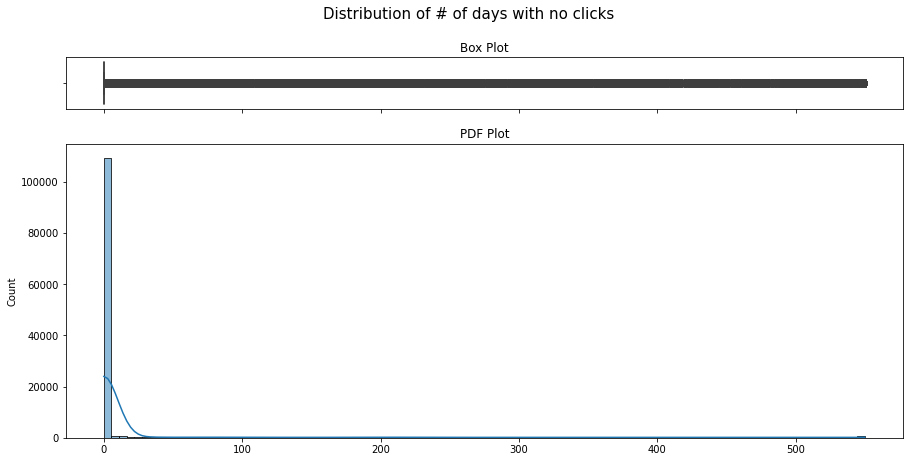

In [ ]:
dist = df.iloc[:, 1:].isnull().sum(axis=1)

make_numerical_plots(dist, '# of days with no clicks ', bins=100)

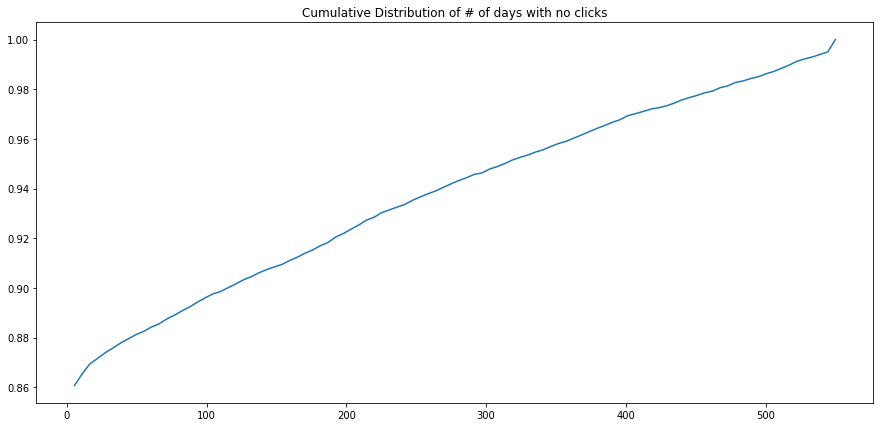

In [ ]:
#  getting data of the histogram
count, bins_count = np.histogram(dist, bins=100)
  
# finding the PDF of the histogram using count values
pdf = count / sum(count)
  
# using numpy np.cumsum to calculate the CDF
# We can also find using the PDF values by looping and adding
cdf = np.cumsum(pdf)

plt.figure(figsize=(15, 7))
plt.plot(bins_count[1:], cdf, label="CDF")
plt.title('Cumulative Distribution of # of days with no clicks')
plt.show()

__Findings__
- More than 90% of pages has less than 200 days of "no-views"
- We will remove the pages with more than 200 days of "no-views" from analysis

In [ ]:
print(f'Total pages --> {df.shape[0]}')
val = (df.isnull().sum(axis=1) > 200).sum()
print('Pages with more than 200 days of no-clicks --> {}'.format(val))

Total pages --> 127208
Pages with more than 200 days of no-clicks --> 9838


In [ ]:
df = df[~(df.isnull().sum(axis=1) > 200)]

In [ ]:
print(f'Total pages are removing less-viewed pages --> {df.shape[0]}')

Total pages are removing less-viewed pages --> 117370


### Splitting the page names 

- We will split the pages names and extract values from it like tittle, language, access type and access origin.

In [ ]:
def split_page_info(x):
    l, r = x.split('.wikipedia.org_')
    title, language = l.rsplit('_', 1)
    access_type, access_origin = r.split('_')
    return (title, language, access_type, access_origin)

In [ ]:
# SPECIFIC NAME _ LANGUAGE.wikipedia.org _ ACCESS TYPE _ ACCESS ORIGIN
df['title'], df['language'], df['access_type'], df['access_origin'] = zip(*df['Page'].apply(split_page_info))

In [ ]:
#demo
x = '2NE1_zh.wikipedia.org_all-access_spider'
y = 'Anexo:Tenis_en_los_Juegos_Olímpicos_de_Río_de_Janeiro_2016_es.wikipedia.org_all-access_spider'

print(split_page_info(x))
print(split_page_info(y))

('2NE1', 'zh', 'all-access', 'spider')
('Anexo:Tenis_en_los_Juegos_Olímpicos_de_Río_de_Janeiro_2016', 'es', 'all-access', 'spider')


In [ ]:
df.tail(3)

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,title,language,access_type,access_origin
145001,La_habitación_(película)_es.wikipedia.org_all-...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,19.0,6.0,6.0,5.0,4.0,1.0,La_habitación_(película),es,all-access,spider
145002,Las_crónicas_de_Shannara_es.wikipedia.org_all-...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,5.0,5.0,4.0,10.0,14.0,Las_crónicas_de_Shannara,es,all-access,spider
145003,Anexo:Espectáculos_de_medio_tiempo_del_Super_B...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,1.0,0.0,4.0,4.0,2.0,Anexo:Espectáculos_de_medio_tiempo_del_Super_Bowl,es,all-access,spider


# EDA

We did some surface scratching and found some basic details. Now we will do in depth exploration of the dataset and try to come up with some possible actionable insights.

In [ ]:
def make_categorical_plots(df, feature):
    """
    Method to make univariate categorical plot
    """

    # creating a figure composed of two matplotlib.Axes objects (ax_count and ax_pie)
    f, (ax_count, ax_pie) = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
    f.suptitle(f'Distribution of {feature}', fontsize=15)

    # assigning a graph to each ax
    data = df[feature].value_counts()

    sns.countplot(data=df, x=feature, order=data.index, ax=ax_count)
    if len(data) > 8:
        ax_count.set_xticklabels(labels=data.index, rotation=70)

    for p in ax_count.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax_count.annotate('{}'.format(int(y)), (x.mean(), y), 
                ha='center', va='bottom')

    #customize plot
    params = {
        'autopct':'%.0f%%',
        'startangle': 90,
        'radius': 1,
        'wedgeprops': {'linewidth': 3},
        'explode': (0.01,)*df[feature].nunique(),
        'textprops': {'size': 'large'}
    }
    #create pie chart
    ax_pie.pie(data.values, labels = data.index, **params)
    plt.show()

## Univariate Analysis

### language

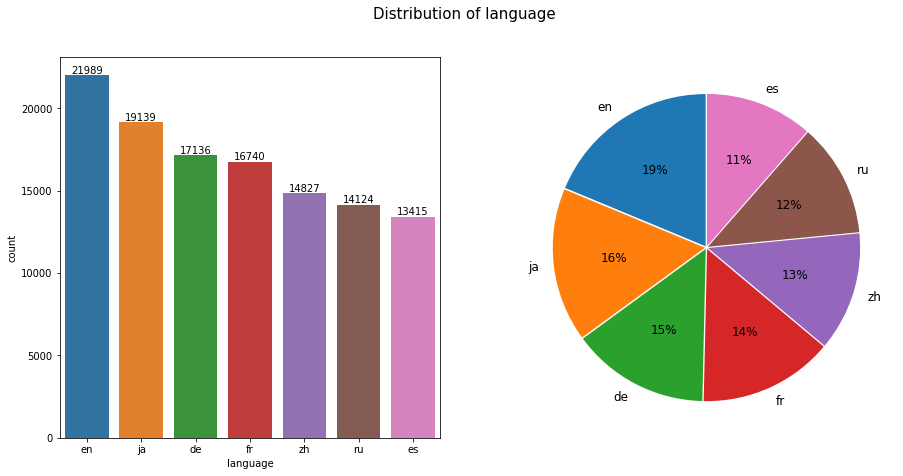

In [ ]:
make_categorical_plots(df, 'language')

__Findings__
- We have pages in 7 different languages, viz en, ja, de, fr, zh, ru, and es
- Most of the pages are in en language. And least in es language

### access_type

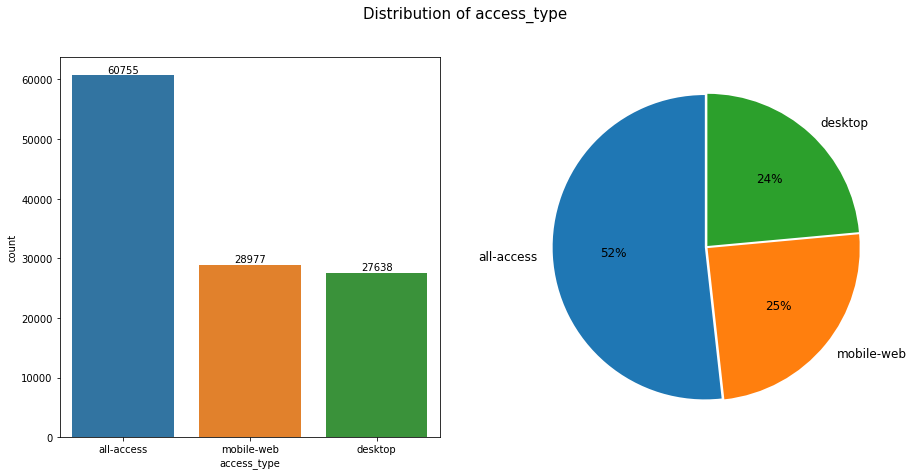

In [ ]:
make_categorical_plots(df, 'access_type')

__Findings__
- Most of the web traffic comes from "all-access", they account for more than half of the total traffic
- "desktop" and "mobile-web" account for almost similar traffic

### access_origin

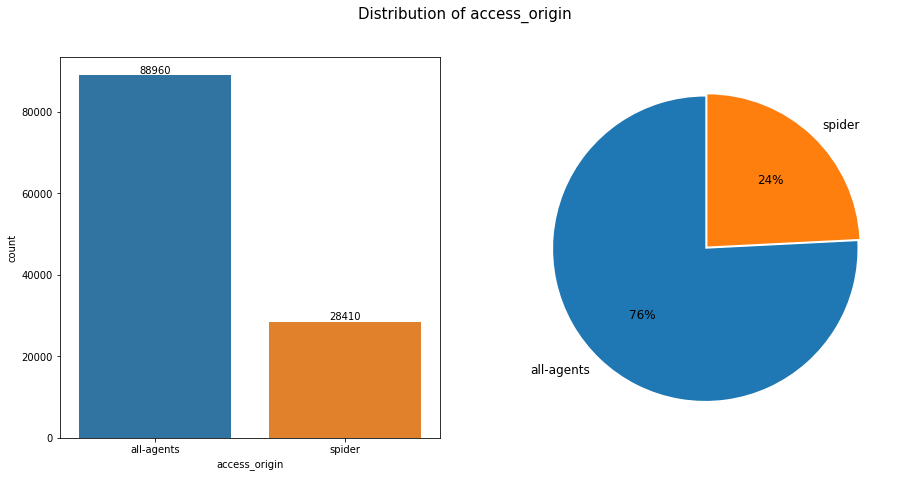

In [ ]:
make_categorical_plots(df, 'access_origin')

__Findings__
- The request origin for 76% of traffic comes from "all-agents".
- 26% of request origin comes from "spider"

## Missing Values

In [ ]:
np.random.seed(21)
df[df.isna().any(axis=1)].sample(5)

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,title,language,access_type,access_origin
49519,陳奕齊_zh.wikipedia.org_desktop_all-agents,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,22.0,10.0,10.0,14.0,21.0,25.0,陳奕齊,zh,desktop,all-agents
85077,Ephialtias_pseudena_en.wikipedia.org_all-acces...,3.0,1.0,2.0,NaN,1.0,2.0,NaN,1.0,2.0,...,1.0,1.0,2.0,2.0,4.0,4.0,Ephialtias_pseudena,en,all-access,all-agents
23491,林榮基_zh.wikipedia.org_all-access_all-agents,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,32.0,54.0,45.0,77.0,79.0,97.0,林榮基,zh,all-access,all-agents
84517,Brasil_Game_Cup_en.wikipedia.org_all-access_al...,1.0,1.0,NaN,NaN,3.0,NaN,NaN,2.0,1.0,...,2.0,1.0,1.0,1.0,3.0,2.0,Brasil_Game_Cup,en,all-access,all-agents
52700,Ant-Man_(Film)_de.wikipedia.org_desktop_all-ag...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,217.0,270.0,274.0,244.0,252.0,177.0,Ant-Man_(Film),de,desktop,all-agents


**Strategies for filling Missing Values**

- Many of the pages were not even live, or tracked in the beginning of the monitoring window, and as such, there are no page views recorded for them. Hence we see the NaNs on the left side. **We will fill them with 0**.

- Once a page goes live and there are missing values on some random days, it suggests that these pages are very unpopular and thus no clicks. We will use 2 different strategies to fill them:

-  -  We will use "forward fill" method to impute the missing values. But we will limit the maximum number of consecutive NaN values to forward fill to 3. This will help us not to overpredict the page views outside of a safer range.
-  -  The values that still remain 0 at at this stage, will be imputed with 0

> **Impute using 'forward fill'**



In [ ]:
idx = df.isna().any(axis=1)

In [ ]:
df.iloc[:, 1:-4] = df.iloc[:, 1:-4].fillna(method='ffill', axis=1, limit=3)

np.random.seed(21)
df[idx].sample(5)

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,title,language,access_type,access_origin
49519,陳奕齊_zh.wikipedia.org_desktop_all-agents,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,22.0,10.0,10.0,14.0,21.0,25.0,陳奕齊,zh,desktop,all-agents
85077,Ephialtias_pseudena_en.wikipedia.org_all-acces...,3.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,...,1.0,1.0,2.0,2.0,4.0,4.0,Ephialtias_pseudena,en,all-access,all-agents
23491,林榮基_zh.wikipedia.org_all-access_all-agents,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,32.0,54.0,45.0,77.0,79.0,97.0,林榮基,zh,all-access,all-agents
84517,Brasil_Game_Cup_en.wikipedia.org_all-access_al...,1.0,1.0,1.0,1.0,3.0,3.0,3.0,2.0,1.0,...,2.0,1.0,1.0,1.0,3.0,2.0,Brasil_Game_Cup,en,all-access,all-agents
52700,Ant-Man_(Film)_de.wikipedia.org_desktop_all-ag...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,217.0,270.0,274.0,244.0,252.0,177.0,Ant-Man_(Film),de,desktop,all-agents


> **Fill all the remaining values with 0**

In [ ]:
df.fillna(0, inplace=True)

np.random.seed(21)
df[idx].sample(5)

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,title,language,access_type,access_origin
49519,陳奕齊_zh.wikipedia.org_desktop_all-agents,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,22.0,10.0,10.0,14.0,21.0,25.0,陳奕齊,zh,desktop,all-agents
85077,Ephialtias_pseudena_en.wikipedia.org_all-acces...,3.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,...,1.0,1.0,2.0,2.0,4.0,4.0,Ephialtias_pseudena,en,all-access,all-agents
23491,林榮基_zh.wikipedia.org_all-access_all-agents,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,32.0,54.0,45.0,77.0,79.0,97.0,林榮基,zh,all-access,all-agents
84517,Brasil_Game_Cup_en.wikipedia.org_all-access_al...,1.0,1.0,1.0,1.0,3.0,3.0,3.0,2.0,1.0,...,2.0,1.0,1.0,1.0,3.0,2.0,Brasil_Game_Cup,en,all-access,all-agents
52700,Ant-Man_(Film)_de.wikipedia.org_desktop_all-ag...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,217.0,270.0,274.0,244.0,252.0,177.0,Ant-Man_(Film),de,desktop,all-agents


__Summary__
- We are done with filling the missing values

## Bivariate Analysis



In [ ]:
def plot_trend(df, feature):

    plt.figure(figsize=(15, 7))

    for lang in df[feature].unique():
        srs = df[df[feature] == lang].iloc[:, 1:-4].mean()
        plt.plot(srs, linewidth=2, label=lang)

    plt.xlabel('Date')
    plt.ylabel('Page View')
    plt.xticks([], [])
    plt.title(f"Avg page view over time V/S {feature}")
    plt.legend()
    plt.show()

### Avg page view over time vs "language"

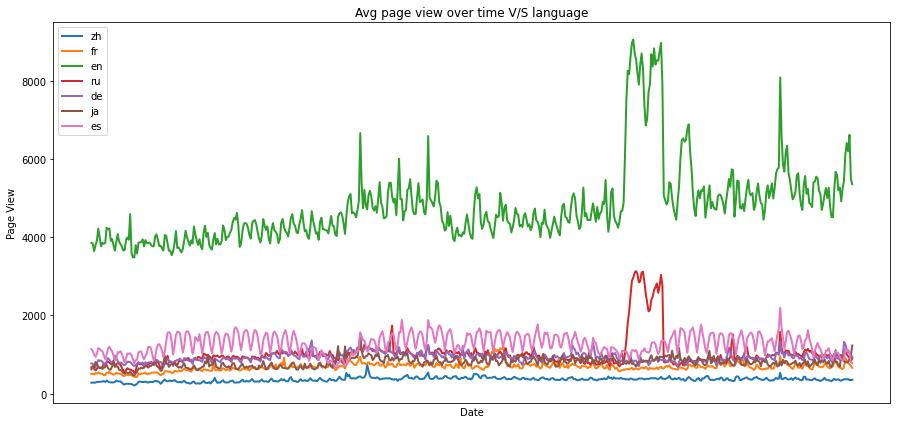

In [ ]:
plot_trend(df, 'language')

__Findings__
- "en" websites have the highest avg page views over time 
- "zh" websites have the lowest avg page views over time
- The remaining languages have similar avg page views over time.
- There is a similar spike for both "ru" and "en" during a period. We will investigate the further to understand the sudden change in the page views

### Avg page view over time vs "access_type"

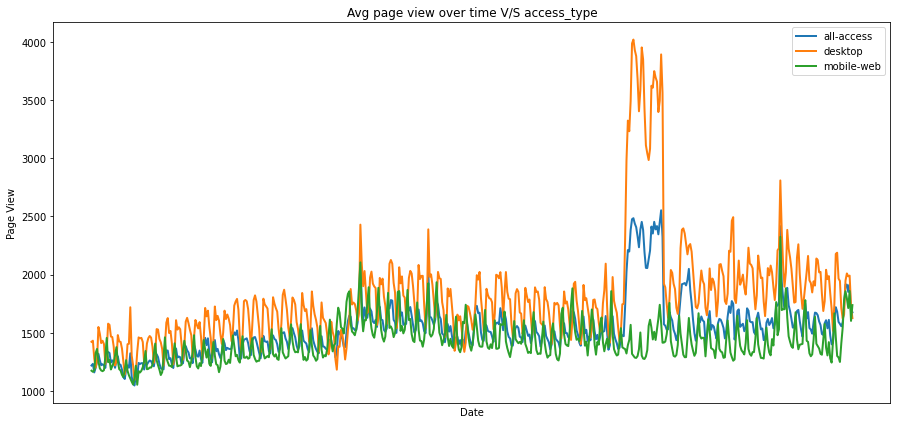

In [ ]:
plot_trend(df, 'access_type')

__Findings__
- The highest traffic comes from "all-access" device
- The traffic from "mobile-web" and "desktop" are similar
- There is a spike similar to the one we observed earlier. We will make further analysis on this time period for better understanding

### Avg page view over time vs "access_origin"

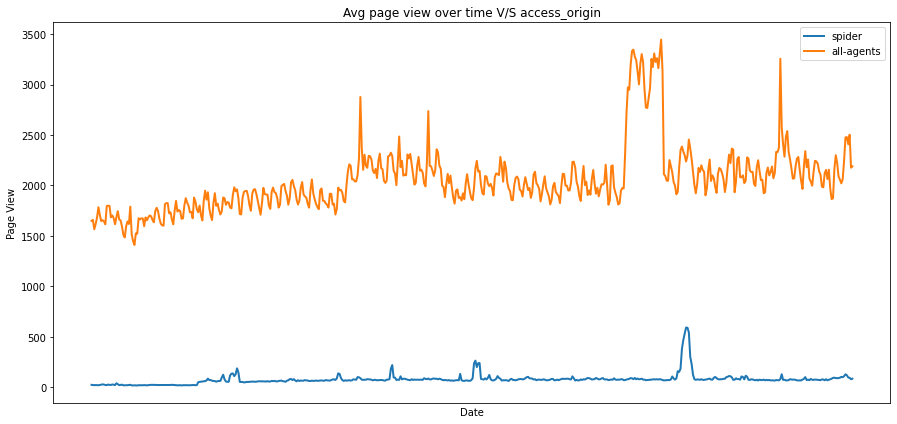

In [ ]:
plot_trend(df, 'access_origin')

__Findings__
- Most of the web request origins come from "all-agents"
- Web request from "spider" is very less.

## EDA Summary

- "en" websites have the highest avg page views over time. "zh" websites have the lowest avg page views over time. The remaining languages have similar avg page views over time.
- Although the numbers are different, the pattern for avg page view over time is similar for all the languages. However, a sudden spike is observed in the "en" and "es" series. The pattern of spike is similar for both.
- There were lots of missing values in the data. The possibilities could be that - a) the pages have significantly fewer clicks, b) the pages were not live, or tracked at the beginning of the 550-day period.

# Data Preparation

- Converting the data to a format that can be fed to the ARIMA model.

In [ ]:
df.head(3)

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,title,language,access_type,access_origin
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,14.0,20.0,22.0,19.0,18.0,20.0,2NE1,zh,all-access,spider
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,9.0,30.0,52.0,45.0,26.0,20.0,2PM,zh,all-access,spider
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,4.0,4.0,6.0,3.0,4.0,17.0,3C,zh,all-access,spider


In [ ]:
dates = df.columns[1:-4]
df_time = pd.DataFrame(index=dates)

for lang in df['language'].unique():
    df_time[lang] = df[df['language'] == lang].mean().to_frame()

tdi = pd.DatetimeIndex(df_time.index)
df_time.set_index(tdi, inplace=True)

print(df_time.shape)

(550, 7)


In [ ]:
df_time.head()

,zh,fr,en,ru,de,ja,es
2015-07-01,279.550482,505.294146,3852.462640,670.053880,773.838761,619.647004,1138.618710
2015-07-02,279.977474,508.540741,3840.042931,681.652223,763.315476,711.566696,1088.118897
2015-07-03,278.122749,488.989367,3645.815226,631.793614,732.615021,642.647892,1000.717182
2015-07-04,280.810953,522.684170,3795.686934,594.253611,672.294935,807.426668,939.574953
2015-07-05,299.537668,513.168220,3920.096366,632.861866,781.536298,774.616333,1021.808423


__Conclusion__
- The dataset is ready for ARIMA models

# Outlier Removal

Time series forecasting is based on the assumption that there is no outliers in the data. As we saw some spikes in the "en" and "ru" data earlier, we will try to remove them using some thresholding method - 

In [ ]:
import seaborn as sns

def check_dist(df, lang):
    # settings
    f, axes = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)
    axes[0].set_ylabel('fraction (PDF)')
    axes[1].set_ylabel('fraction (CDF)')
    f.suptitle(f'PDF and CDF for {lang}')

    sns.distplot(
        df[lang], bins=100, kde=True, axlabel='PDF', ax=axes[0]
    )
    sns.distplot(
        df[lang], bins=100, kde=False, axlabel='CDF',
        hist_kws={"cumulative":True}, ax=axes[1],
    )
    plt.show()

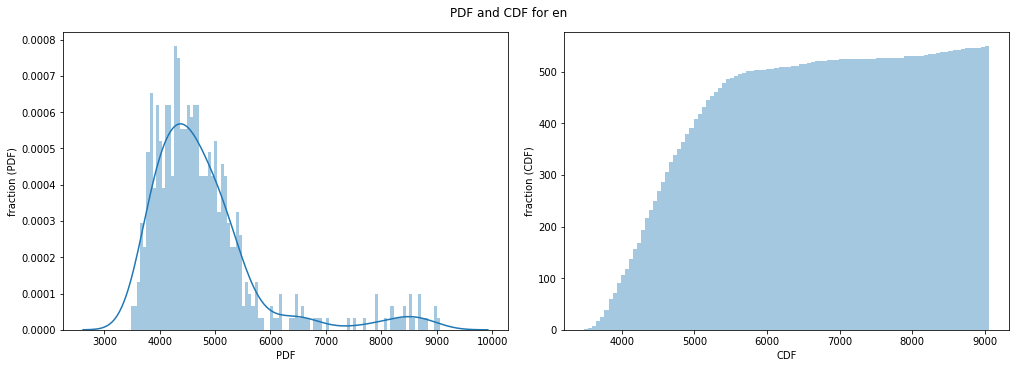

In [ ]:
check_dist(df_time, 'en')

__Findings__
- We can cap the values exceeding 7000 to 7000

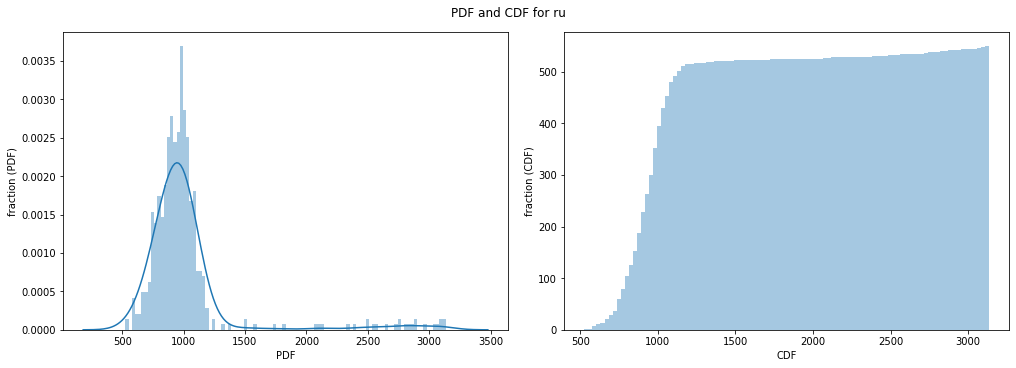

In [ ]:
check_dist(df_time, 'ru')

__Findings__
- We can cap the values exceeding 1600 to 1600

In [ ]:
cap_dict = {'en': 7000, 'ru': 1600}

for lang in ['en', 'ru']:
    df_time[df_time[lang] > cap_dict[lang]] = cap_dict[lang]

__CHECKING DATA AFTER OUTLIER REMOVAL__

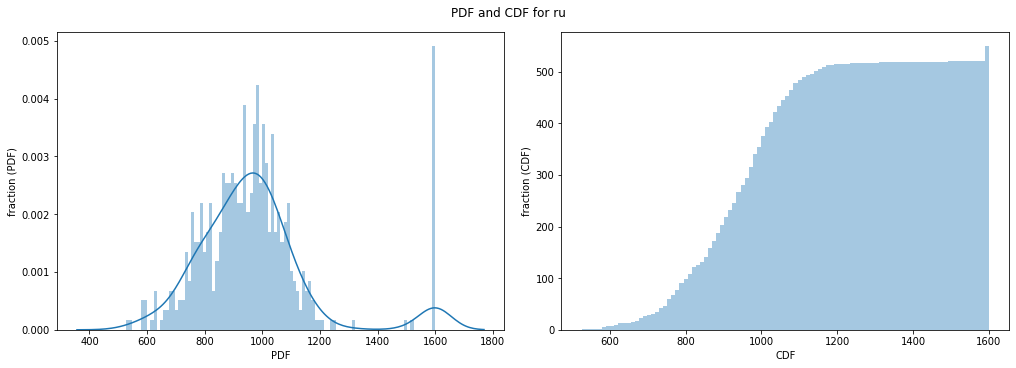

In [ ]:
check_dist(df_time, 'ru')

__Findings__
- The distribution looks better now

# Stationarity


A series is said to be stationary if the basic properties of the distribution like mean, variance, and covariance do not change over time. The data is considered non-stationary if there is a strong trend or seasonality in the data.



## How to check if the series is stationary or not?

> **Decomposition + ADFuller Test**

- The simplest and most convenient way is to look at the chart directly to see whether there is a clear trend or seasonality observed.
- We will try to decompose the series into trends and seasonality, and see if they are stationary or not.
- We will also use the ADF fuller test statistic to check for stationarity.

In [ ]:
import statsmodels.api as sm
plt.rcParams['figure.figsize'] = (13, 5)

In [ ]:
def check_stationarity(df, lang):
    result = sm.tsa.stattools.adfuller(df[lang])
    print(f'{" "*8} {lang} Series --> p-value: {result[1]} --> ', end='')
    if result[1] <= 0.05:
        print('Series is stationary')
    else:
        print('Series is non-stationary')

    model = sm.tsa.seasonal_decompose(df[lang], model='additive')
    model.plot();

         en Series --> p-value: 0.0009083062235008813 --> Series is stationary


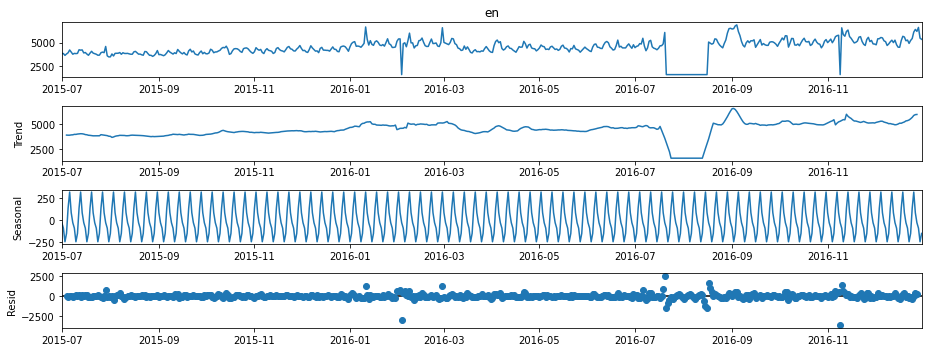

In [ ]:
check_stationarity(df_time, 'en')

         de Series --> p-value: 0.001439504509467756 --> Series is stationary


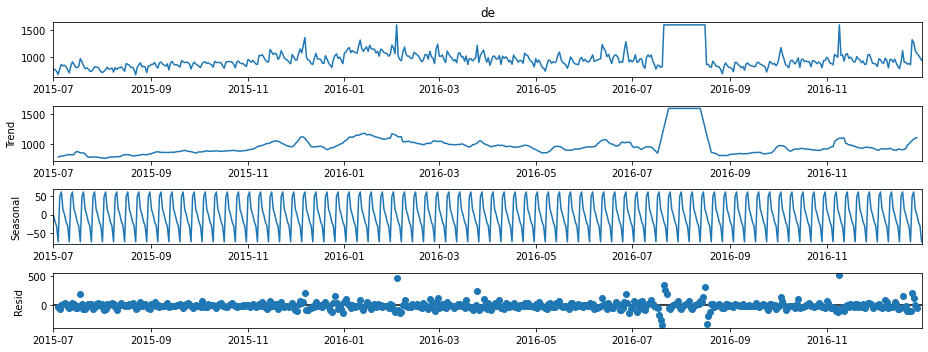

In [ ]:
check_stationarity(df_time, 'de')

         ja Series --> p-value: 0.0448081698540185 --> Series is stationary


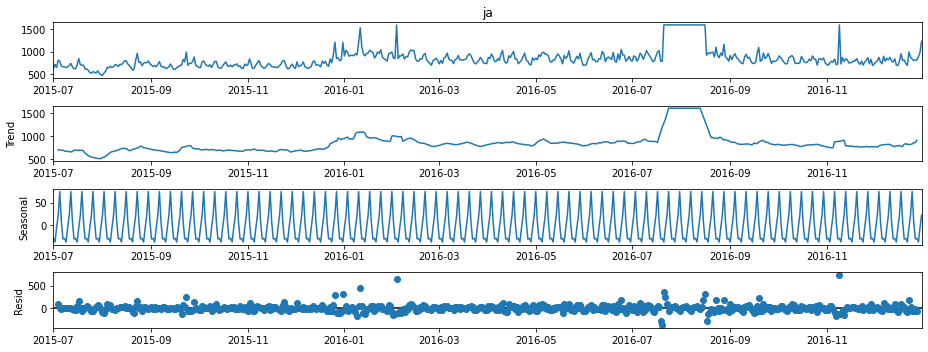

In [ ]:
check_stationarity(df_time, 'ja')

         zh Series --> p-value: 0.005100351303006286 --> Series is stationary


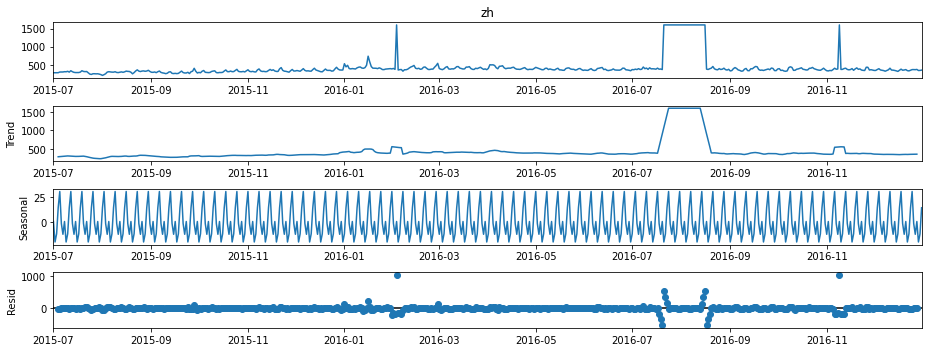

In [ ]:
check_stationarity(df_time, 'zh')

         ru Series --> p-value: 0.0004914379163653122 --> Series is stationary


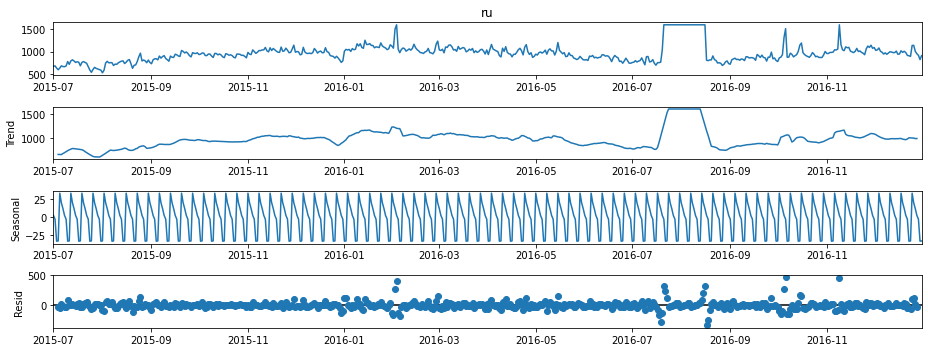

In [ ]:
check_stationarity(df_time, 'ru')

         es Series --> p-value: 0.019122188558795664 --> Series is stationary


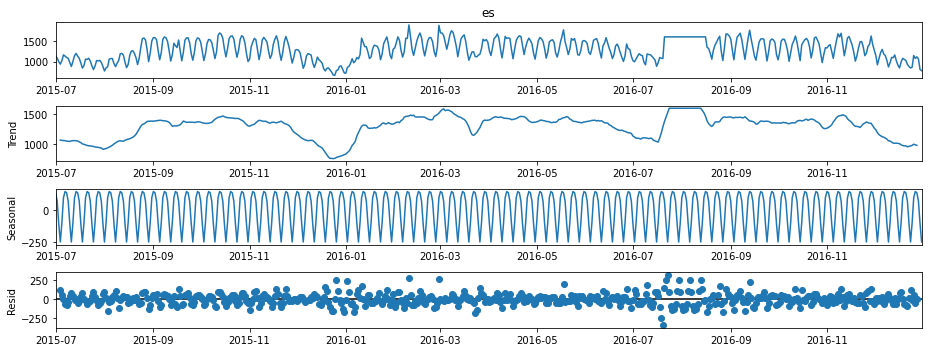

In [ ]:
check_stationarity(df_time, 'es')

         fr Series --> p-value: 0.0024324350954291916 --> Series is stationary


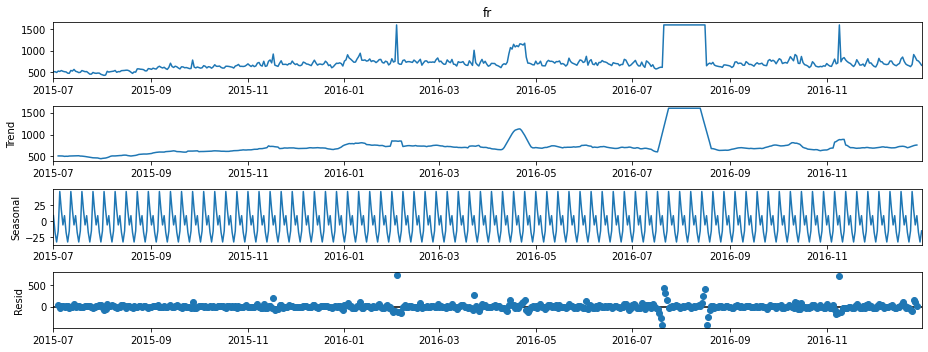

In [ ]:
check_stationarity(df_time, 'fr')

__Findings__

- Although there exists some trend/seasonality in all the series, the ADFuller test still suggests that the series are stationary. We will try to applying DIFFERENCING on these series and see how they look


## What to do if the series is non-stationary?



>  **Differencing**

- Differencing can help stabilise the mean of a time series by removing changes in the level of a time series, and therefore eliminating (or reducing) trend and seasonality.

In [ ]:
def check_stationarity_detrended(df, lang, lag):
    detrend = df[lang].diff(lag).fillna(0)
    detrend.plot(title=f"Detrend series for {lang} (Diff={lag})")
    detrend.rolling(365).mean().plot()

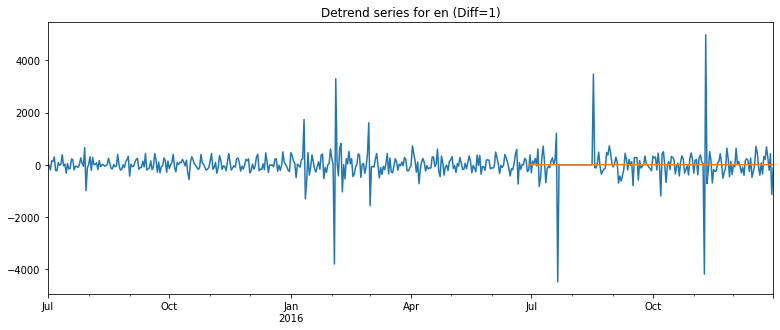

In [ ]:
check_stationarity_detrended(df_time, 'en', 1)

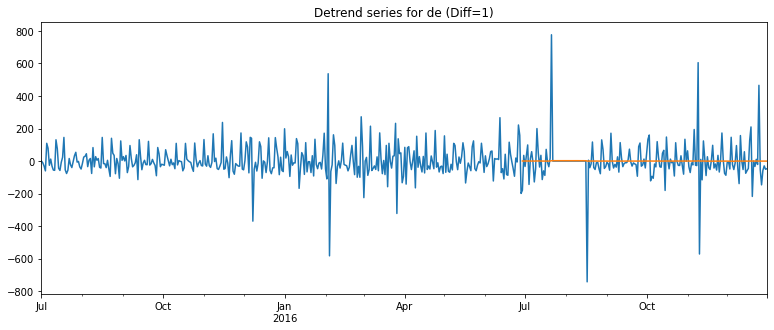

In [ ]:
check_stationarity_detrended(df_time, 'de', 1)

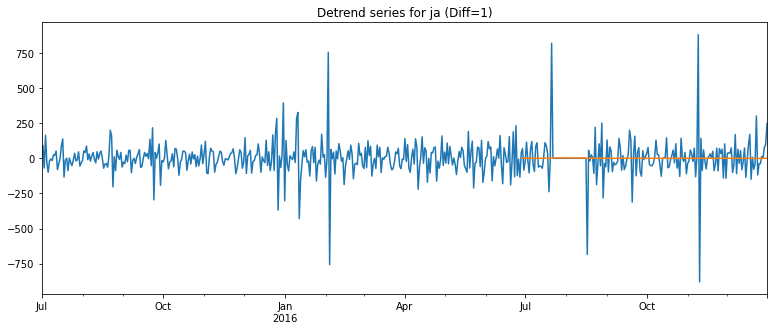

In [ ]:
check_stationarity_detrended(df_time, 'ja', 1)

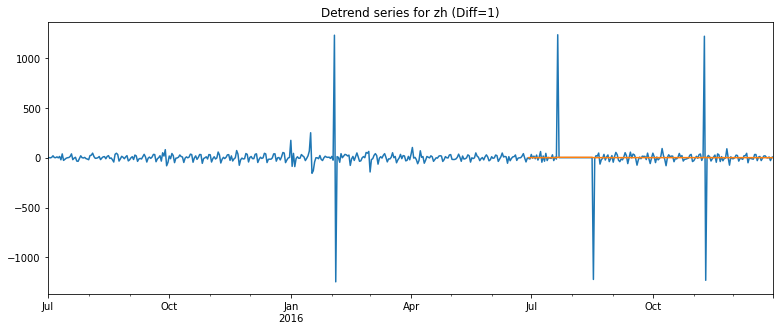

In [ ]:
check_stationarity_detrended(df_time, 'zh', 1)

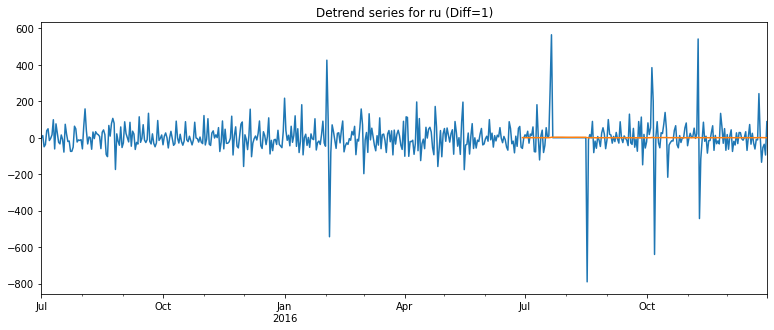

In [ ]:
check_stationarity_detrended(df_time, 'ru', 1)

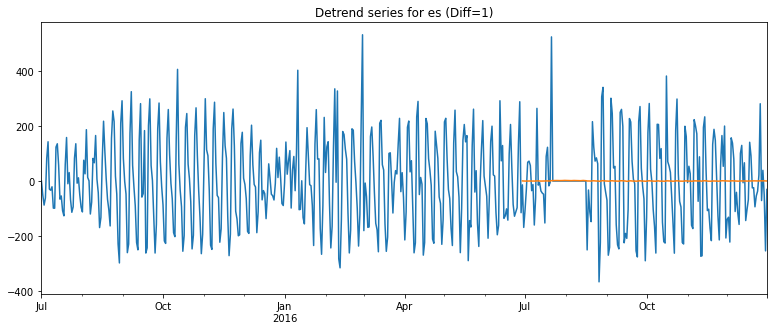

In [ ]:
check_stationarity_detrended(df_time, 'es', 1)


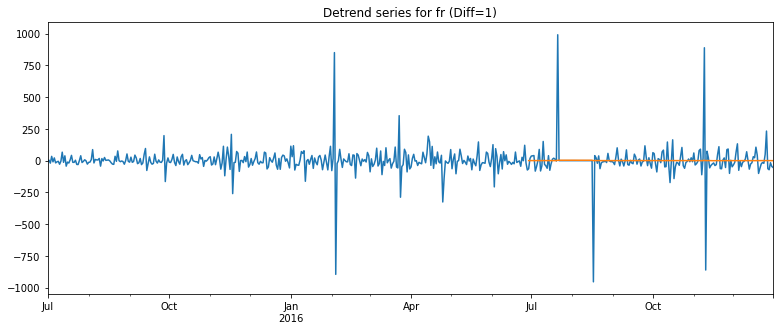

In [ ]:
check_stationarity_detrended(df_time, 'fr', 1)


__Findings__
- All the series seems to look stationary after one differencing
- The peaks are some noise

# ACF and PACF plot

The autocorrelation analysis helps in detecting hidden patterns and seasonality and in checking for randomness. It is especially important when we intend to use an ARIMA model for forecasting because the autocorrelation analysis helps us identify the AR and MA parameters for the ARIMA model.

We will use the following table information to infer the values of p, and q.

![Imgur](https://i.imgur.com/sfg9HkD.png)






In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
def plot_autocorrelation(df, lang):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7))
    # make ACF plot
    plot_acf(df[lang], ax=ax1)
    # make PACF plot
    plot_pacf(df[lang], ax=ax2)
    plt.show()

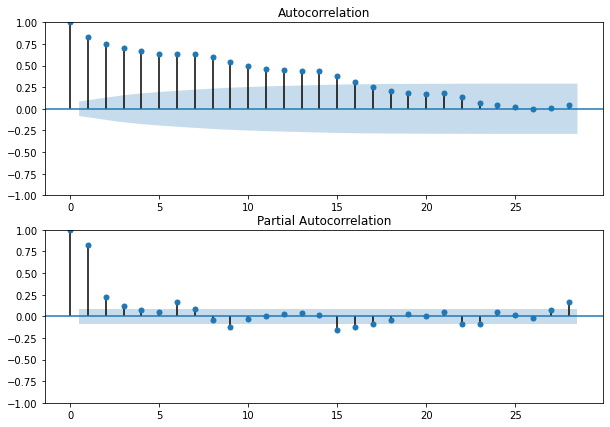

In [ ]:
plot_autocorrelation(df_time, 'en')

__Findings__
- "en" series looks like an AR(1) model

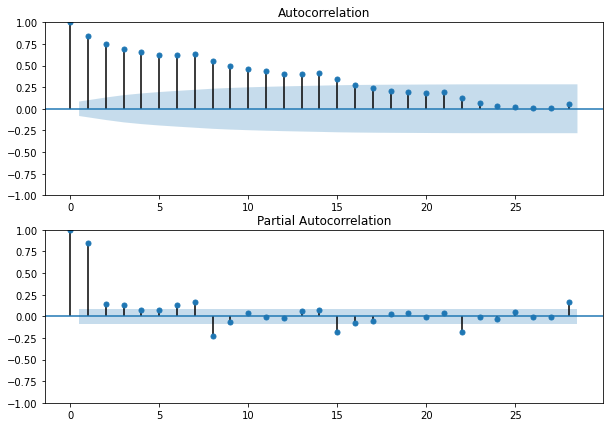

In [ ]:
plot_autocorrelation(df_time, 'de')

__Findings__
- "de" series looks like an AR(1) model

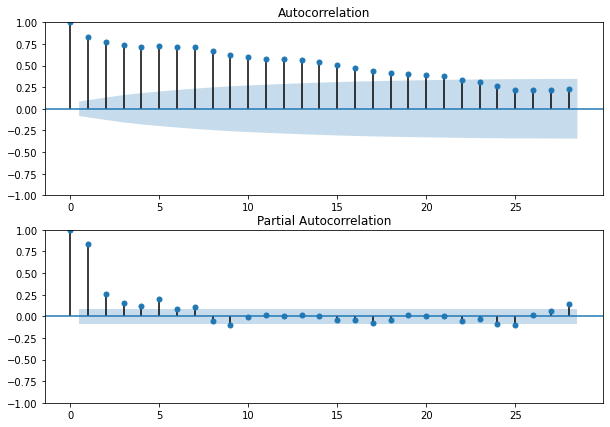

In [ ]:
plot_autocorrelation(df_time, 'ja')

__Findings__
- "ja" series looks like an AR(1) model

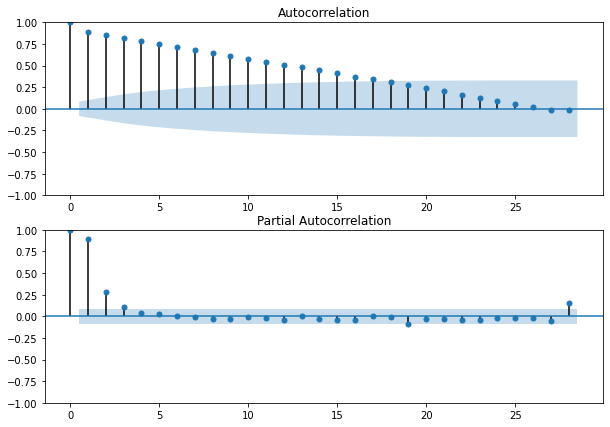

In [ ]:
plot_autocorrelation(df_time, 'zh')

__Findings__
- "zh" series looks like an AR(2) model

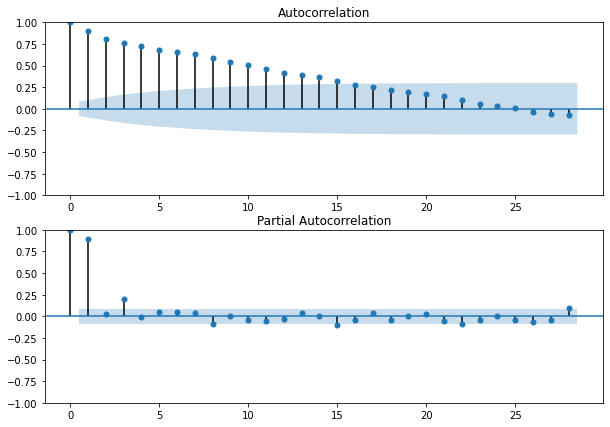

In [ ]:
plot_autocorrelation(df_time, 'ru')

__Findings__
- "ru" series looks like an AR(1) model

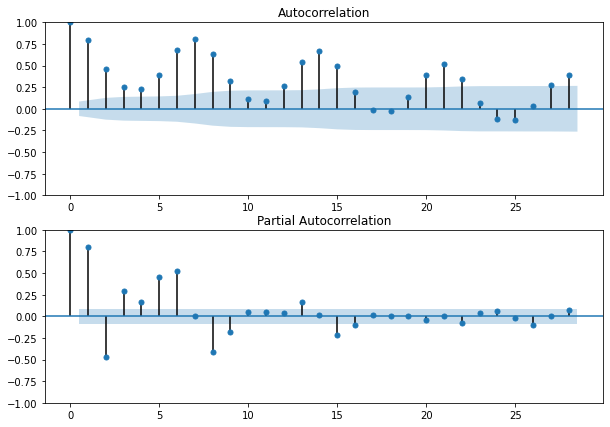

In [ ]:
plot_autocorrelation(df_time, 'es')

__Findings__
- "es" series looks like an ARMA model

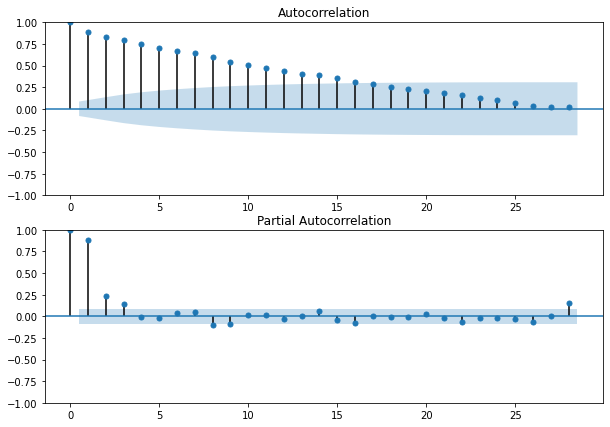

In [ ]:
plot_autocorrelation(df_time, 'fr')

__Findings__
- "fr" series looks like an AR(2) model

__Summary__
- Basic ACF and PACF suggests some of can be modelling simply using AR model, and some would require ARMA model. 

# Modelling




### Train - Test split

In [ ]:
!pip install pmdarima

In [ ]:
from pmdarima.model_selection import train_test_split

In [ ]:
exo_df = pd.read_csv('../Exog_Campaign_eng')

exo_df.set_index(df_time.index, inplace=True)
exo_df.head()

,Exog
2015-07-01,0
2015-07-02,0
2015-07-03,0
2015-07-04,0
2015-07-05,0


In [ ]:
df_train, df_test, exo_train, exo_test = train_test_split(df_time, exo_df, test_size=110)

__Summary__
- We are keep latest 110 days as test set. And the older 440 days will be used for modelling

### ARIMA

#### Auto Arima to find best params 

Although we figure out the possible "p", "d", and "q" for the series in the analysis above, we will use gridsearch to find the best param. 

In order to find the best combination of "p" and "q", we need to have some objective function that will measure model performance on a validation set.  Usually, we can use AIC and BIC for that purpose. The lower the value of these criteria, the better the model is. 

Below is a quick comparision of the two criterion:



|AIC|BIC|
|--|--|
|Lower AIC indicates a better model|Same as AIC|
|AIC likes to choose simple models <br> with lower order|BIC favors simpler models <br>than AIC|
|AIC is better at choosing <br> predictive models| BIC is better at choosing good<br> explanatory models|


**NOTE**: We will use AIC criterion in our analysis.

In [ ]:
import pmdarima as pmd

__Finding the best params__

In [ ]:
def arimamodel(timeseriesarray, exogenous=None):
    autoarima_model = pmd.auto_arima(timeseriesarray, 
                                     start_p=1, # auto-regressive (AR)
                                     start_q=2, # moving average
                                     test="adf", # ADF Augmented Dickey-Fuller test.
                                     trace=True,
    )
    return autoarima_model

In [ ]:
arima_model = arimamodel(df_train['en'])
parameter = arima_model.get_params().get('order')
print(f'Optimal order for is: {parameter} \n')

Performing stepwise search to minimize aic
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6621.068, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6656.320, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6640.185, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6631.763, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6654.334, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=6621.285, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6619.489, Time=0.34 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6621.001, Time=0.62 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6630.722, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6614.928, Time=1.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=6622.689, Time=0.80 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=6622.608, Time=1.31 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=6623.101, Time=0.56 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=6623.007, Time=0.60 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept

__Findings__
- The best (p, d, q) param for "en" series is (5,1,3)
- Similarly we can find the best params for all the series

In [ ]:
def get_best_params(df_train):
    best_params_dict = {}
    for lang in ['en', 'de', 'ja', 'zh', 'ru', 'es', 'fr']:
        arima_model = arimamodel(df_train[lang])
        parameter = arima_model.get_params().get('order')
        print(f'Optimal order for {lang} is {parameter} \n')
        best_params_dict[lang] = parameter
    return best_params_dict

best_params_dict = get_best_params(df_train)


Performing stepwise search to minimize aic
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=5271.145, Time=0.79 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=5910.671, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=5285.212, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=5586.198, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=7324.538, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=5458.745, Time=0.31 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=5278.546, Time=0.45 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=5272.454, Time=0.95 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=5272.515, Time=0.72 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=5409.360, Time=0.49 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=5272.065, Time=0.75 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=5274.278, Time=0.79 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=5282.082, Time=0.13 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0] intercept
Total fit time: 5.681 seconds
Optimal order for de i

In [ ]:
best_params_dict

{'en': (5, 1, 3),
 'de': (1, 0, 2),
 'ja': (1, 1, 1),
 'zh': (0, 1, 1),
 'ru': (2, 0, 2),
 'es': (4, 1, 5),
 'fr': (1, 0, 1)}

__Summary__
- We found out the best param values for the ARIMA model. 
- We can now continue with the modelling part and see how they work

#### Training the model.


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import (
    mean_absolute_percentage_error as mape
)

In [ ]:
def performance(true, pred):
    return np.round(mape(true, pred), 3)
    
def train_forecast_model(train, test, params_dict):

    test_scores = []
    res = pd.DataFrame()

    for lang in train.columns:

        model = SARIMAX(train[lang], order=params_dict[lang])
        model = model.fit(disp=False)

        res[lang]  = model.forecast(steps=110)
        test_scores.append(performance(test[lang] , res[lang]))

    return res, pd.DataFrame({'lang': list(train.columns), 'MAPE_test': test_scores})

def plot_forecasts(test, pred, score_df, title):

    f, ax = plt.subplots(7, sharex=True, figsize=(14, 20), constrained_layout=True)
    
    f.suptitle(f'{title}', fontsize=14)
    for idx, lang in enumerate(test.columns):
        ax[idx-1].set_title(f'{lang} --> {score_df.iloc[idx]["MAPE_test"]}')
        ax[idx-1].plot(test[lang], label=f'true values')
        ax[idx-1].plot(pred[lang], label=f'forecast values')
        ax[idx-1].legend(loc="upper right")

    plt.show()

__Training + Forecasting on the test set__

In [ ]:
pred_df, score_df = train_forecast_model(df_train, df_test, best_params_dict)

__Plotting the forecast on test data__

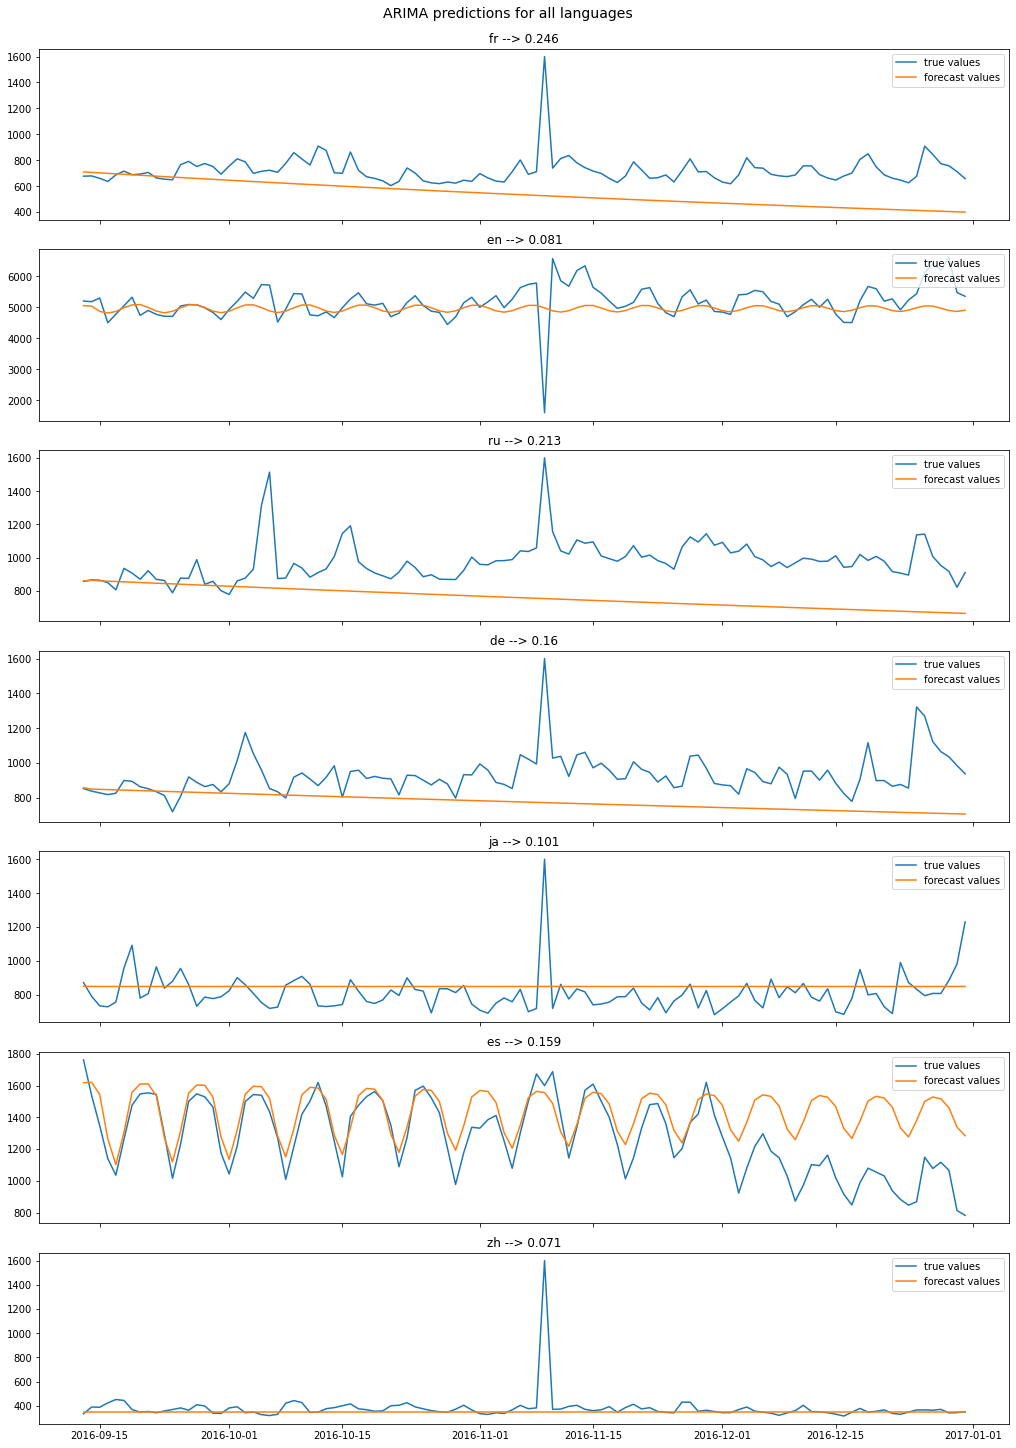

In [ ]:
plot_forecasts(df_test, pred_df, score_df, 'ARIMA predictions for all languages')

In [ ]:
print('MAPE scores')
score_df

MAPE scores


,lang,MAPE_test
0,zh,0.071
1,fr,0.246
2,en,0.081
3,ru,0.213
4,de,0.160
5,ja,0.101
6,es,0.159


__Findings__
- The model tends to perform descent for "zh" and "en"
- The forecasting is very poor for other models

## SARIMAX

#### auto_arima to find best params 

In [ ]:
def sarimaxmodel(timeseriesarray, exogenous=None):
    sarimax_model = pmd.auto_arima(timeseriesarray, 
                                     start_p=1, # auto-regressive (AR)
                                     start_q=2, # moving average
                                     test="adf",# ADF Augmented Dickey-Fuller test.
                                     trace=True,
                                     seasonal=True,
                                     m=12,
                                     exogenous=exogenous
    )
    return sarimax_model

In [ ]:
sarimax_model = sarimaxmodel(df_train['en'], exo_df)
parameter = sarimax_model.get_params().get('order')
print(f'Optimal order for is: {parameter} \n')

Performing stepwise search to minimize aic
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=3.07 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6656.320, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=6640.546, Time=0.25 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=6632.566, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6654.334, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=6631.763, Time=0.21 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=6632.574, Time=0.59 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=6634.546, Time=1.52 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=6619.489, Time=0.34 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=6621.019, Time=0.90 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=6620.862, Time=1.58 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=6622.774, Time=2.65 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=6640.185, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=6621.001, Time=0.62 sec
 ARIMA(1,1,2)(0,0,0)[12]

__Findings__
- The best (p, d, q) param for "en" series is (5,1,3)
- Similarly we can find the best params for all the series

In [ ]:
def get_best_paramsx(df_train, exo_df):

    best_params_dictx = {}
    for lang in ['en', 'de', 'ja', 'zh', 'ru', 'es', 'fr']:
        sarimax_model = sarimaxmodel(df_train[lang], exo_df)
        parameter = sarimax_model.get_params().get('order')
        print(f'Optimal order for {lang} is {parameter} \n')
        best_params_dictx[lang] = parameter
    return best_params_dictx = {}

best_params_dictx = get_best_paramsx(df_train, exo_df)

Performing stepwise search to minimize aic
 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=3.24 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=5910.671, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=5286.085, Time=0.94 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=5531.817, Time=0.71 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=7324.538, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=5285.212, Time=0.07 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=5285.990, Time=0.29 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=5287.976, Time=2.45 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=5281.212, Time=0.25 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=5280.847, Time=2.49 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=5279.622, Time=6.51 sec
 ARIMA(2,0,0)(2,0,1)[12] intercept   : AIC=5281.416, Time=5.83 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=5282.581, Time=2.09 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=5285.868, Time=4.12 sec
 ARIMA(3,0,0)(2,0,0)[12]

In [ ]:
best_params_dictx

{'en': (5, 1, 3),
 'de': (4, 0, 0),
 'ja': (1, 1, 1),
 'zh': (0, 1, 1),
 'ru': (2, 0, 2),
 'es': (4, 1, 5),
 'fr': (1, 0, 1)}

__Summary__
- We found out the best param values for the SARIMAX model. 
- No seasonality pattern was detected in the series 
- We can now continue with the modelling part and see how they work. One thing to notice is that, there is no seasonality in the data

#### Training the model.


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import (
    mean_absolute_percentage_error as mape
)

In [ ]:
def train_forecast_modelx(train, test, exog_tr, exog_te, params_dict):

    test_scores = []
    res = pd.DataFrame()

    for lang in train.columns:
        # training the model
        model = SARIMAX(train[lang], exog=exog_tr, order=params_dict[lang], enforce_invertibility=False)
        model = model.fit()

        # forecasting
        res[lang]  = model.forecast(steps=110, exog=exog_te)
        test_scores.append(performance(test[lang] , res[lang]))

    # forecasted series, language wise MAPE
    return res, pd.DataFrame({'lang': list(train.columns), 'MAPE_test': test_scores})

__Training + Forecasting on the test data__

In [ ]:
pred_df, score_df = train_forecast_modelx(df_train, df_test, exo_train, exo_test, best_params_dictx)

__Plotting the forecast on test data__

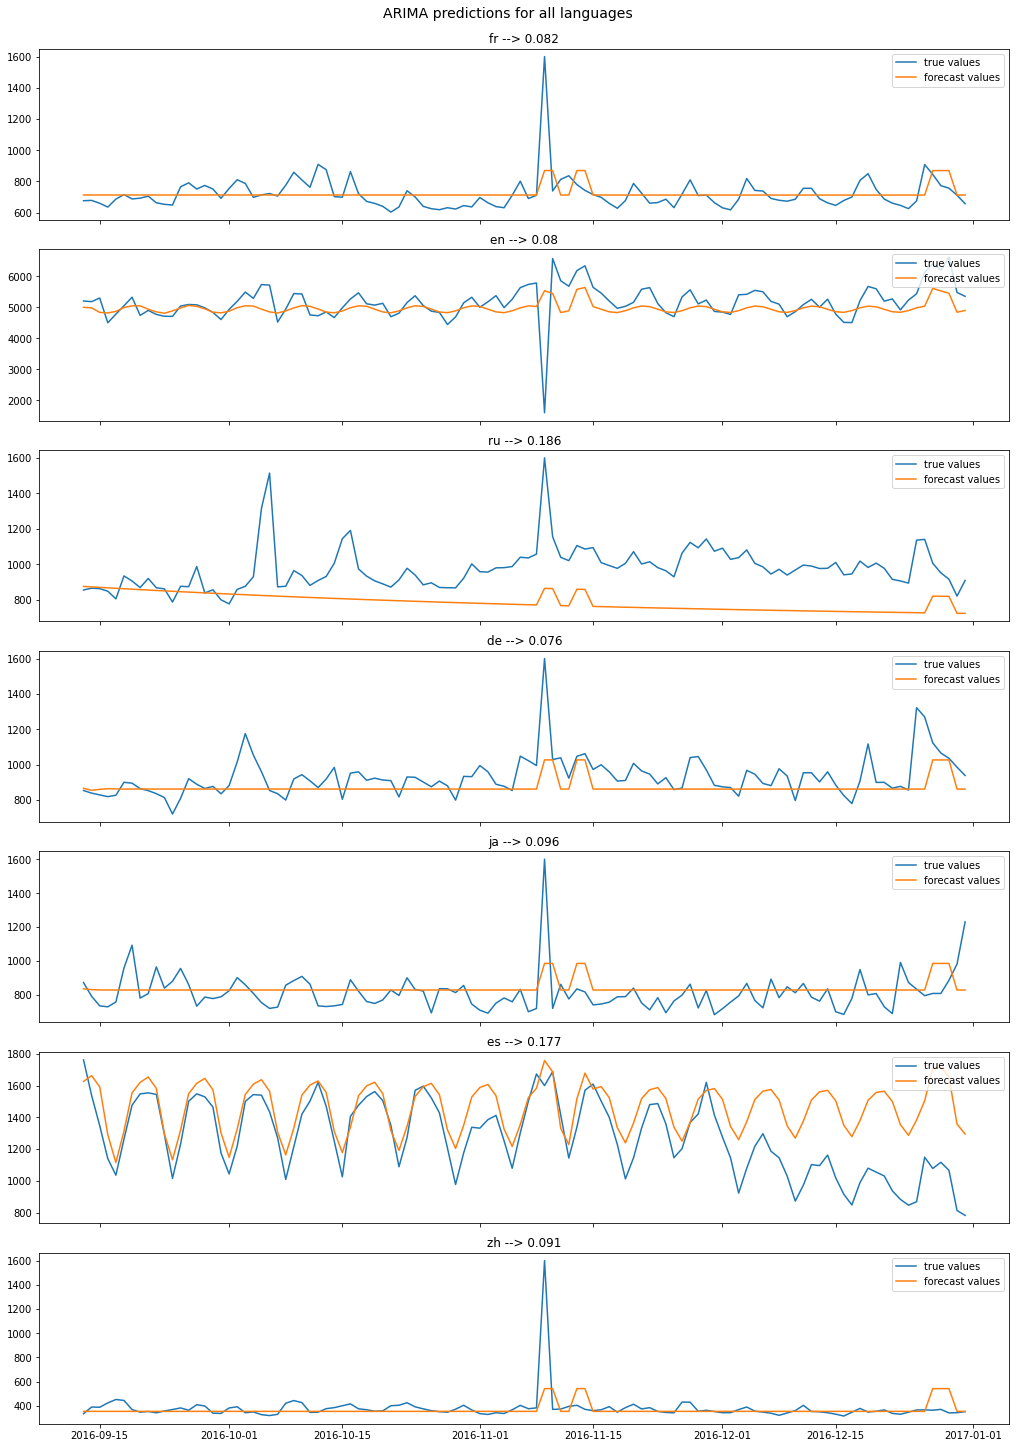

In [ ]:
plot_forecasts(df_test, pred_df, score_df, 'SARIMAX predictions for all languages')


In [ ]:
score_df #SARIMAX  fr, en, ru, de, ja  --> zh es

,lang,MAPE_test
0,zh,0.091
1,fr,0.082
2,en,0.080
3,ru,0.186
4,de,0.076
5,ja,0.096
6,es,0.177


__Findings__
- As no seasonality was found in the data, the "p", "d", and "q" params still remains the same.
- However, using exogenous variables during modelling helped improved the forecasting for most of the series
- Predictions on "fr", "en", "ru", "de" and "ja" improved after using exogenous variables
- The predictions on "zh" and "es" deteriorated, but only slightly.

## Regression

In [ ]:
from pmdarima.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV

We can come up with the following types of features for Regression:
- Rolling Window Statistics: Min, Max, Mean, Variance
- Date Time features: weekday, month, week, quarter
- Lagged Features (5 timestamps used here)
- Double Exponential Smoothing

### Data Preparation

In [ ]:
def prepare_data(df):

    df_dict = {}
    
    for lang in df.columns:
        series = df[[lang]].copy()

        # add lagged feautures (5 timestamps)
        for idx in range(1, 6):
            series[f't-{idx}'] = series[lang].shift(idx)

        # add rolling window statistics (window size = 3)
        width = 3
        shifted = series[lang].shift(width - 1)
        window = shifted.rolling(window=width)
        series['rolling_min'] = window.min()
        series['rolling_max'] = window.max()
        series['rolling_mean']= window.mean()
        series['rolling_var'] = window.var()
        
        # add date-time features
        series['month']      = [idx.month for idx in series.index]
        series['dayofweek']  = [idx.dayofweek for idx in series.index]
        series['weekofyear'] = [idx.week for idx in series.index]
        series['quarter']    = [idx.quarter for idx in series.index]

        # double exponential smoothing
        model = sm.tsa.ExponentialSmoothing(series[lang], trend='add').fit(smoothing_level=0.4)
        series['des'] = model.fittedvalues

        # dropped any rows with missing values
        series.dropna(inplace=True)
        df_dict[lang] = series
    
    return df_dict

In [ ]:
df_dict = prepare_data(df_time)

for k, v in df_dict.items():
    print(k, v.shape)

zh (545, 15)
fr (545, 15)
en (545, 15)
ru (545, 15)
de (545, 15)
ja (545, 15)
es (545, 15)


In [ ]:
df_dict['zh'].head(3)

,zh,t-1,t-2,t-3,t-4,t-5,rolling_min,rolling_max,rolling_mean,rolling_var,month,dayofweek,weekofyear,quarter,des
2015-07-06,301.095097,299.537668,280.810953,278.122749,279.977474,279.550482,278.122749,280.810953,279.637059,1.893522,7,0,28,3,309.493116
2015-07-07,300.758346,301.095097,299.537668,280.810953,278.122749,279.977474,278.122749,299.537668,286.157123,136.085839,7,1,28,3,305.161817
2015-07-08,308.610238,300.758346,301.095097,299.537668,280.810953,278.122749,280.810953,301.095097,293.814573,127.426987,7,2,28,3,302.419531


__Conclusions__
- Data preparation complete

### Training Regression model

In [ ]:
def split_train_test(df_dict):

    trainx_dict = {}
    testx_dict  = {}
    trainy_dict = {}
    testy_dict  = {}

    for lang, df in df_dict.items():
        X, y = df.iloc[:, 1:], df[lang]
        df_train, df_test, y_train, y_test = train_test_split(X, y, test_size=110)

        trainx_dict[lang], testx_dict[lang] = df_train, df_test
        trainy_dict[lang], testy_dict[lang] = y_train, y_test

    return trainx_dict, testx_dict, trainy_dict, testy_dict

def train_model_gridsearch(X, y):

    best_estimators = {}
    scalers = {}
    for lang, df in X.items():
        print(f'*** Training {lang} Series ***')

        logreg = SGDRegressor(loss='squared_loss',penalty='l2', random_state = 42, max_iter=2000)
        tuned_parameters = [{'alpha': [10**-4,10**-3,10**-2,10**-1,1,10,100,1000]}]
        sc = StandardScaler()
        df = sc.fit_transform(df)

        tscv = TimeSeriesSplit(n_splits=3).split(df)
        clf = GridSearchCV(logreg, tuned_parameters, cv = tscv, scoring = 'neg_mean_squared_error', return_train_score=True)
        clf.fit(df, y[lang])

        print(f'The best hyperparameter value is: alpha = {clf.best_estimator_.alpha}')
        best_estimators[lang] = clf.best_estimator_
        scalers[lang] = sc
        print('\n')
    return best_estimators, scalers

def forecast_series(testx, testy, estimator_dict, scalers):

    test_scores = []
    res = pd.DataFrame()

    for lang, clf in estimator_dict.items():
        # forecasting
        df = scalers[lang].transform(testx[lang])
        res[lang]  = clf.predict(df)
        # evaluation
        test_scores.append(np.round(mape(testy[lang] , res[lang]), 3))

    # forecasted series, language wise MAPE
    return res, pd.DataFrame({'lang': list(testx.keys()), 'MAPE_test': test_scores})


def plot_forecast(test, pred, score_df, title):

    f, ax = plt.subplots(7, sharex=True, figsize=(14, 20), constrained_layout=True)
    
    f.suptitle(f'{title}', fontsize=14)
    for idx, lang in enumerate(pred.columns):
        ax[idx-1].set_title(f'{lang} --> {score_df.iloc[idx]["MAPE_test"]}')
        ax[idx-1].plot(test[lang], label=f'true values')
        ax[idx-1].plot(pd.DataFrame({'en': pred[lang], 'date': test[lang].index}).set_index('date'), 
                       label=f'forecast values')
        ax[idx-1].legend(loc="upper right")
    plt.show()

__Split the data to train and test__

In [ ]:
# split the data into train and test
trainx_dict, testx_dict, trainy_dict, testy_dict = split_train_test(df_dict)

__Train the regression models__

In [ ]:
# returns the best estimators, and StandardScaler objects
best_estimators, scalers = train_model_gridsearch(trainx_dict, trainy_dict)

*** Training zh Series ***
The best hyperparameter value is: alpha = 0.001


*** Training fr Series ***
The best hyperparameter value is: alpha = 0.1


*** Training en Series ***
The best hyperparameter value is: alpha = 0.01


*** Training ru Series ***
The best hyperparameter value is: alpha = 1


*** Training de Series ***
The best hyperparameter value is: alpha = 1


*** Training ja Series ***
The best hyperparameter value is: alpha = 0.001


*** Training es Series ***
The best hyperparameter value is: alpha = 1




__Making forecast on the test data__

In [ ]:
# forecast on test data, and compute MAPE
forecast, scores = forecast_series(testx_dict, testy_dict, best_estimators, scalers)

__Plotting the forecast on test data__

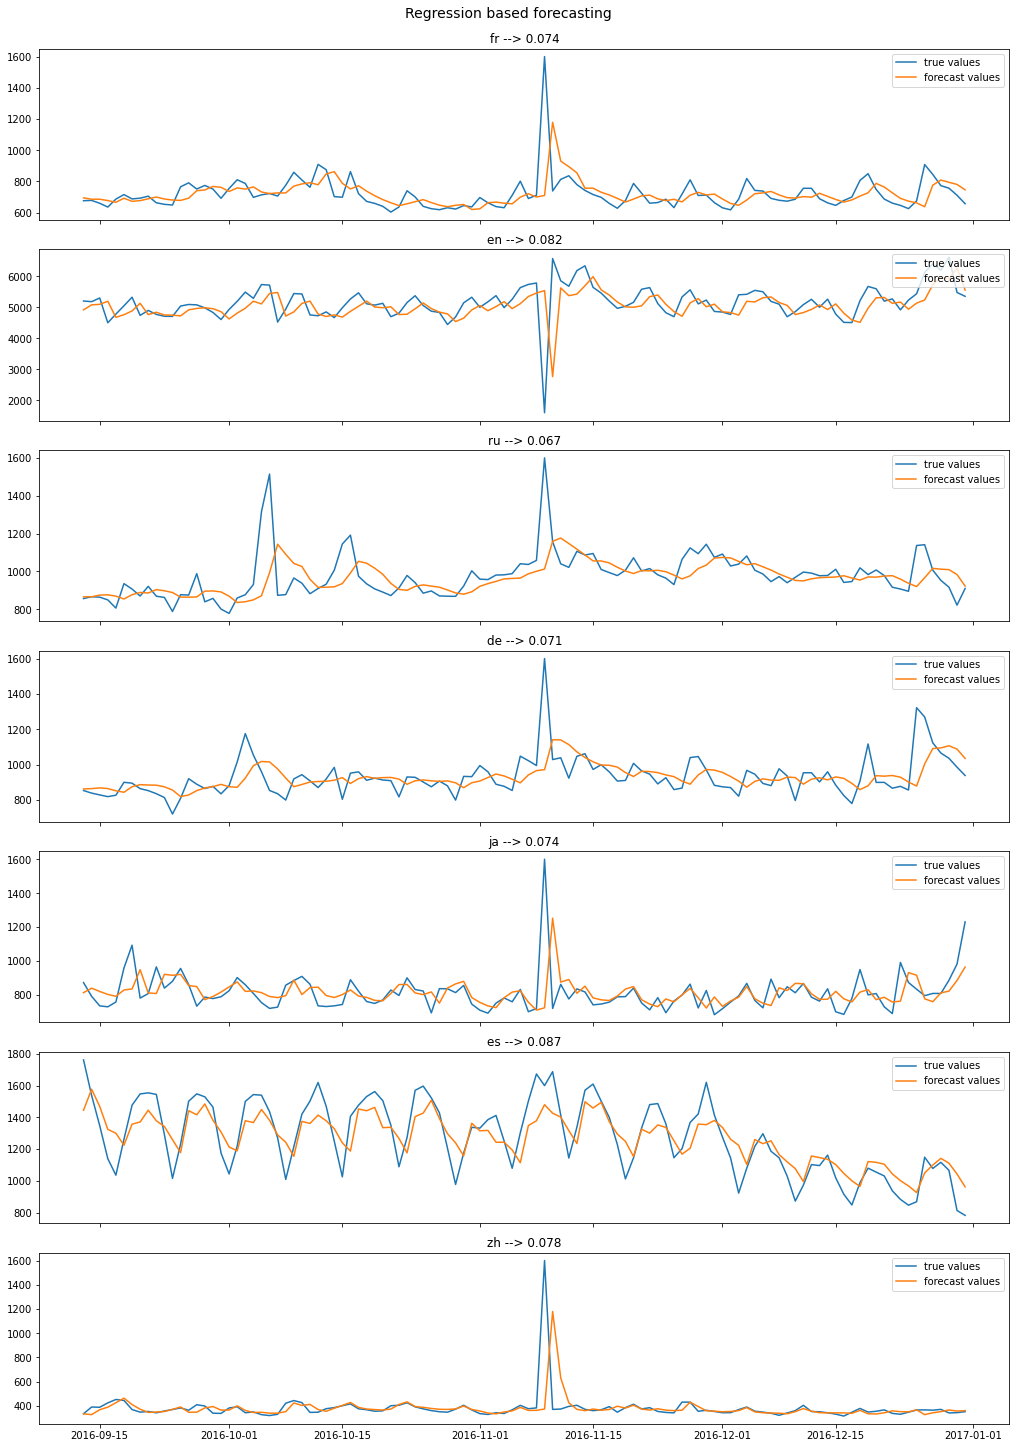

In [ ]:
plot_forecast(testy_dict, forecast, scores, 'Regression based forecasting')

In [ ]:
scores regre

,lang,MAPE_test
0,zh,0.078
1,fr,0.074
2,en,0.082
3,ru,0.067
4,de,0.071
5,ja,0.074
6,es,0.087


__Summary__
- The forecasting have improved significantly over ARIMA and SARIMAX models


## FB Prophet

In [ ]:
# !pip install prophet
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import itertools

In [ ]:
def find_best_params(df, all_params):

    best_params = {}

    for lang in ['zh', 'fr', 'en', 'ru', 'de', 'ja', 'es']:
        rmses = []
        # Use cross validation to evaluate all parameters
        for params in all_params:

            data = df[[lang] + ['exo', 'ds']].copy()
            data.rename(columns={lang: 'y'}, inplace=True)

            m = Prophet(**params).add_regressor('exo').fit(data)  # Fit model with given params
            df_cv = cross_validation(m, period='30 days', horizon = '30 days', parallel="processes")
            df_p = performance_metrics(df_cv, rolling_window=1)
            rmses.append(df_p['rmse'].values[0])

            best_param = all_params[np.argmin(rmses)]
            best_params[lang] = best_param

        print(f"Best params for {lang} --> {best_params[lang]}")

    return best_params

def train_best_models(df, params_dict):

    final_models = {}

    for lang in ['zh', 'fr', 'en', 'ru', 'de', 'ja', 'es']:

        data = df[[lang] + ['exo', 'ds']].copy()
        data.rename(columns={lang: 'y'}, inplace=True)

        model = Prophet(**params_dict[lang]).add_regressor('exo').fit(data)

        final_models[lang] = model

    return final_models

def forecast_series_prophet(models, test):

    preds = test[['ds']].copy().reset_index(drop=True)
    mapes = []

    for lang in ['zh', 'fr', 'en', 'ru', 'de', 'ja', 'es']:
        data = test[[lang] + ['exo', 'ds']].copy()
        data.rename(columns={lang: 'y'}, inplace=True)

        pred = models[lang].predict(data)
        preds[lang] = pred['yhat']
        mapes.append(np.round(mape(data['y'], preds[lang]), 3))

    preds.set_index('ds', inplace=True)
    scores = pd.DataFrame({'lang': ['zh', 'fr', 'en', 'ru', 'de', 'ja', 'es'], 'MAPE_test': mapes})
    return preds, scores


def plot_forecast_prophet(test, pred, score_df, title):

    f, ax = plt.subplots(7, sharex=True, figsize=(14, 20), constrained_layout=True)
    
    f.suptitle(f'{title}', fontsize=14)
    for idx, lang in enumerate(score_df['lang']):
        ax[idx-1].set_title(f'{lang} --> {score_df.iloc[idx]["MAPE_test"]}')
        ax[idx-1].plot(test.set_index('ds')[lang], label=f'true values')
        ax[idx-1].plot(pred[lang], label=f'forecast values')
        ax[idx-1].legend(loc="upper right")

    plt.show()

### Preparing the data for Prophet

In [ ]:
df_time['exo'] = exo_df['Exog'].values
df_time.reset_index(inplace=True)
df_time.rename(columns={'index': 'ds'}, inplace=True)
df_time.head(3)

,ds,zh,fr,en,ru,de,ja,es,exo
0,2015-07-01,279.550482,505.294146,3852.462640,670.053880,773.838761,619.647004,1138.618710,0
1,2015-07-02,279.977474,508.540741,3840.042931,681.652223,763.315476,711.566696,1088.118897,0
2,2015-07-03,278.122749,488.989367,3645.815226,631.793614,732.615021,642.647892,1000.717182,0


### Training Prophet model

__Splitting the data into train and test__

In [ ]:
# train test split
df_train, df_test = train_test_split(df_time, test_size=110)

__Gridsearch to find best params__

In [ ]:
param_grid = {  
    'seasonality_mode':('multiplicative', 'additive'),
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}
# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

best_params = find_best_params(df_train, all_params)

Best params for ja --> {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
Best params for de --> {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
Best params for ru --> {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0}
Best params for en --> {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01}
Best params for fr --> {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01}
Best params for zh --> {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1}
Best params for es --> {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0}


__Train models with the best params__

In [ ]:
final_models = train_best_models(df_train, best_params)

In [ ]:
final_models

{'zh': <prophet.forecaster.Prophet at 0x7f16687e1d50>,
 'fr': <prophet.forecaster.Prophet at 0x7f166d1b7d50>,
 'en': <prophet.forecaster.Prophet at 0x7f1668340590>,
 'ru': <prophet.forecaster.Prophet at 0x7f1667f3f4d0>,
 'de': <prophet.forecaster.Prophet at 0x7f166ce62950>,
 'ja': <prophet.forecaster.Prophet at 0x7f166839be10>,
 'es': <prophet.forecaster.Prophet at 0x7f166d245150>}

__Forecast on test data__

In [ ]:
forecast, scores = forecast_series_prophet(final_models, df_test)

__Plotting the forecast on test data__

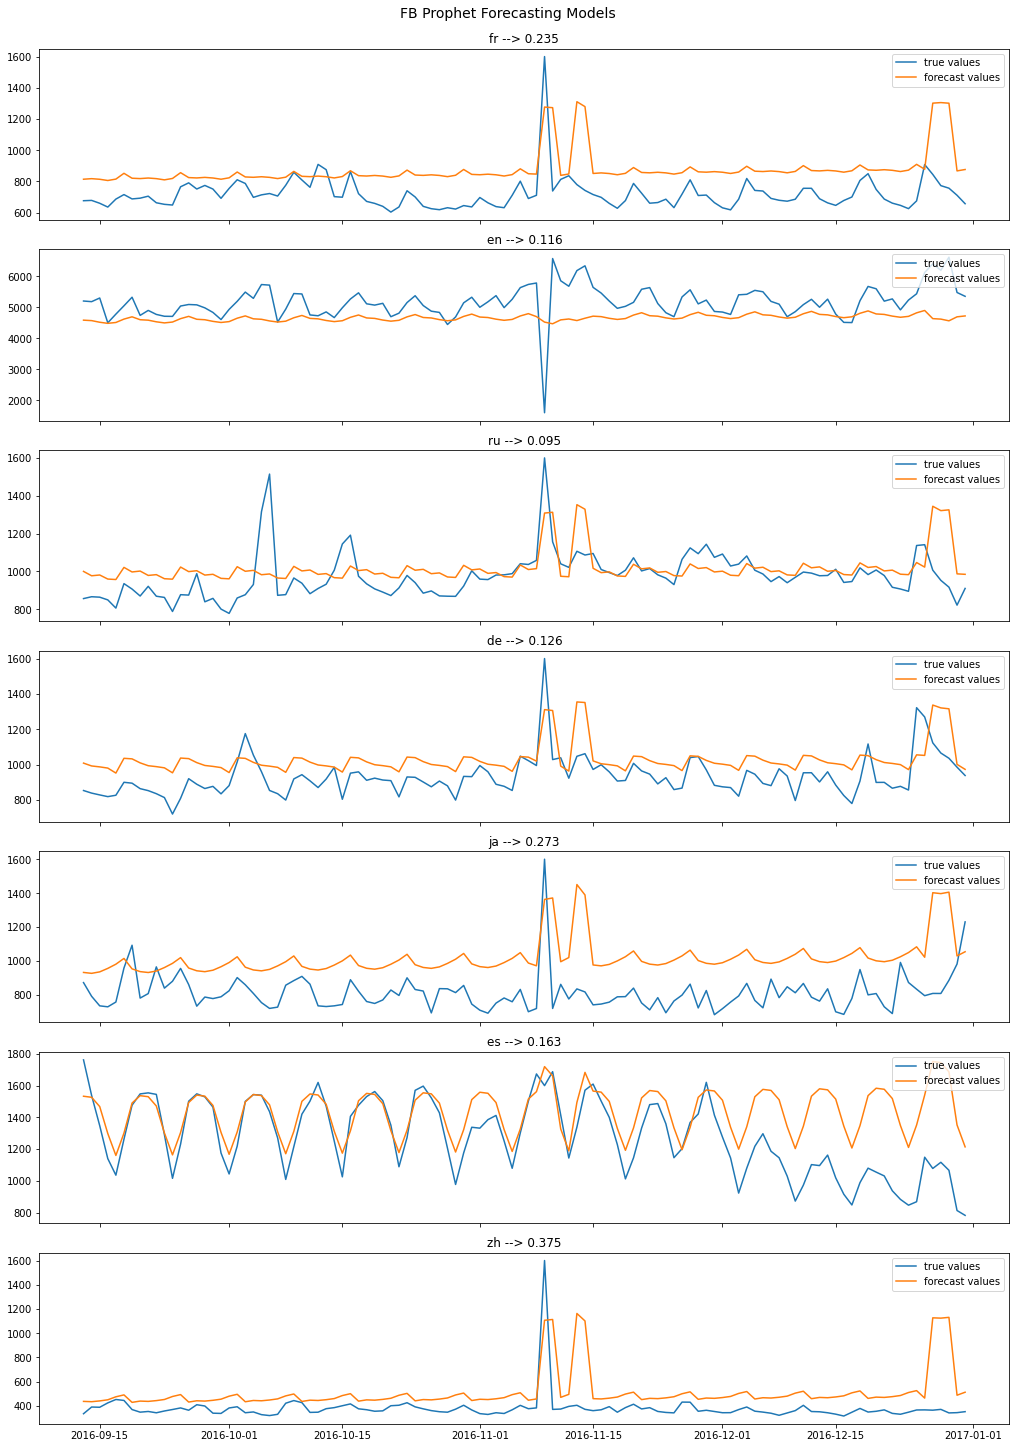

In [ ]:
plot_forecast_prophet(df_test, forecast, scores, 'FB Prophet Forecasting Models')

In [ ]:
scores

,lang,MAPE_test
0,zh,0.375
1,fr,0.235
2,en,0.116
3,ru,0.095
4,de,0.126
5,ja,0.273
6,es,0.163


__Summary__
- The forecasts are not that great
- For some of the series it is giving worse performance than the simple ARIMA and SARIMAX models.

# Summary

### Comparision of Results

In [ ]:
def get_color(x):
    mn, mx = min(x), max(x)
    res = []
    for i in x:
        if i == mn:
            res.append(f"\033[1;32m {str(i)} \033[0m")
        elif i == mx:
            res.append(f"\033[1;31m {str(i)} \033[0m")
        else:
            res.append(i)
    return res

In [ ]:
language = ['zh', 'fr', 'en', 'ru', 'de', 'ja', 'es']
arima =   [0.071, 0.246, 0.081, 0.213, 0.160, 0.101, 0.159]
sarimax = [0.091, 0.082, 0.080, 0.186, 0.076, 0.096, 0.177]
regression = [0.078, 0.074, 0.082, 0.067, 0.071, 0.074, 0.087]
prophet = [0.375, 0.235, 0.116, 0.095, 0.126, 0.273, .163]

In [ ]:
x = PrettyTable(["Language", "ARIMA", "SARIMAX", "Regression", "Prophet"]) 
for l, a, s, r, p in zip(language, arima, sarimax, regression, prophet):
    x.add_row([l] + get_color([a, s, r, p]))
    x.add_row([' ', ' ', ' ', ' ', ''])
print(x)

+----------+---------+---------+------------+---------+
| Language |  ARIMA  | SARIMAX | Regression | Prophet |
+----------+---------+---------+------------+---------+
|    zh    |  0.071  |  0.091  |   0.078    |  0.375  |
|          |         |         |            |         |
|    fr    |  0.246  |  0.082  |   0.074    |  0.235  |
|          |         |         |            |         |
|    en    |  0.081  |   0.08  |   0.082    |  0.116  |
|          |         |         |            |         |
|    ru    |  0.213  |  0.186  |   0.067    |  0.095  |
|          |         |         |            |         |
|    de    |   0.16  |  0.076  |   0.071    |  0.126  |
|          |         |         |            |         |
|    ja    |  0.101  |  0.096  |   0.074    |  0.273  |
|          |         |         |            |         |
|    es    |  0.159  |  0.177  |   0.087    |  0.163  |
|          |         |         |            |         |
+----------+---------+---------+------------+---

**NB**
- Green --> Best Score
- Red --> Worst Score

__Summary__
- The regression model is the best one to forecast for "fr", "ru", "de", "ja", and "es"
- The ARIMA model is the best one to forecast "zh"
- The SARIMAX model is the best one to forecast "en" 
- **The MAPE are in the range of 6-8%.**

# Recommendations:



In [2]:
observations = [
    """en websites have the highest average page views over time. 
    zh websites have the lowest average page views over time.""",

    """The 'average page views' series for all the languages are
    stationary. And, the regression based models has the lowest 
    MAPE for most of the languages.""",
    
    """ARIMA and SARIMAX also gave the lowest MAPE for some
    of the languages. However, the AR and MA coefficients inferred 
    from the PACF and ACF plots are not the same as returned by 
    auto_arima models.""" ,
    ]


recommendations = [
    """The company should focus more on clients whose target audiences follow
    English websites, and least on clients whose target audiences follow
    Chinese websites.
    """ ,

    """The company can deploy simple Regression models to forecast page views.
    As the series are stationary, the Regression models can give a 
    good interpretable results.""",

    """The company should hire some expert statisticians to understand the
    nitty-gritty of the series if they wish to deploy ARIMA/SARIMAX 
    based models."""
    ]

x = PrettyTable(["Sl no", "Observations", "Recommendations"]) 
i = 1
for a, b in zip(observations, recommendations):
    x.add_row([i, a, b])
    x.add_row([' ', ' ', ' '])
    i += 1
print(x)

+-------+---------------------------------------------------------------------+--------------------------------------------------------------------------+
| Sl no |                             Observations                            |                             Recommendations                              |
+-------+---------------------------------------------------------------------+--------------------------------------------------------------------------+
|   1   |     en websites have the highest average page views over time.      |  The company should focus more on clients whose target audiences follow  |
|       |        zh websites have the lowest average page views over time.    |     English websites, and least on clients whose target audiences follow |
|       |                                                                     |                              Chinese websites.                           |
|       |                                                             